In [75]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
from skimage import measure
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sklearn.cluster
import itertools
import statistics
import cv2
import scipy

Populating the interactive namespace from numpy and matplotlib


In [77]:
chemin = "drive/MyDrive/BME/Artificial_Intelligence_in_Data_Science/class_2/"

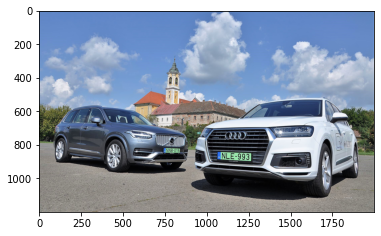

In [78]:
img = mpimg.imread(chemin+"DSC_2144.jpg")
imgplot = plt.imshow(img)
plt.show()

In [79]:
img.shape

(1200, 2000, 3)

## Segmentation

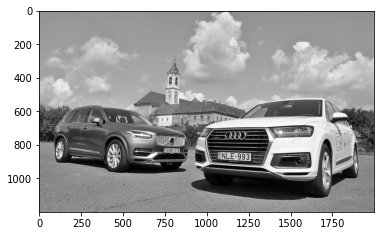

In [80]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gimg,cmap='gray')
plt.show()

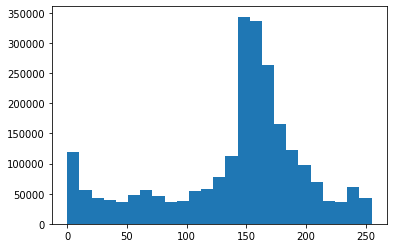

In [81]:
plt.hist(gimg.flatten(),bins=25);

### Mean

In [82]:
print(gimg.mean())

140.67478916666667


### Otsu
<pre>threshold(src, thresh, maxval, type[, dst])</pre> 

In [83]:
thr,res = cv2.threshold(gimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(thr)

107.0


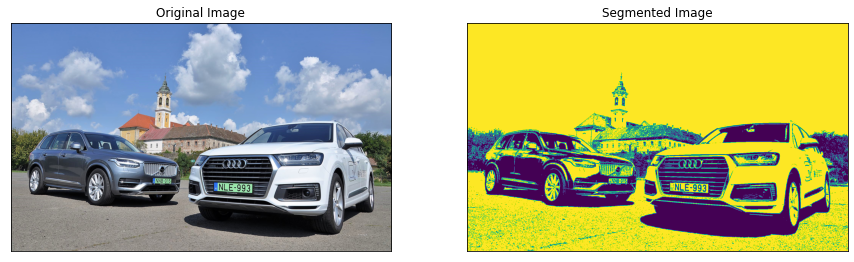

In [84]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()

### TASK: segment the image according to mean

In [85]:
def segment_by_mean(img, mean):
  new_image = (img < mean)
  return new_image

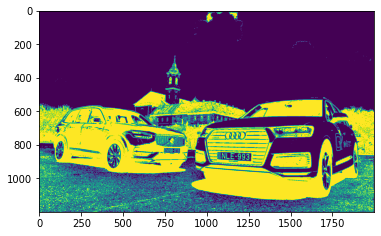

In [86]:
imgplot = plt.imshow(segment_by_mean(gimg,gimg.mean()))
plt.show()

### k-means clustering in RGB space

In [87]:
r = img[::20,::20,0].flatten()
g = img[::20,::20,1].flatten()
b = img[::20,::20,2].flatten()
np.shape(r)

(6000,)

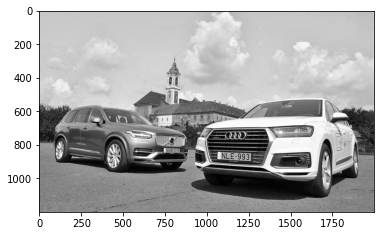

In [88]:
plt.imshow(img[:,:,2],cmap='gray')
plt.show()

### RGB space

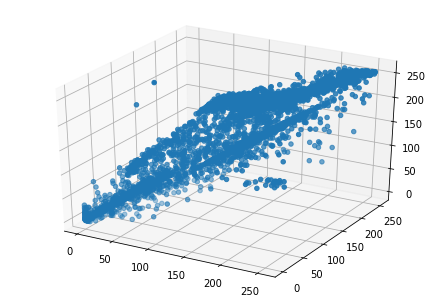

In [89]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

### K-means clustering
Segment the image into two parts using k-means clustering

First we need to flatten the 2d image

In [90]:
print(img.shape)
print(img.reshape((-1,3)).shape)

(1200, 2000, 3)
(2400000, 3)


### Warning
You can stop the next command if it takes too long! And this is just a 2.4 megapixel image!

In [91]:
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb)

In [92]:
kmeans.cluster_centers_

array([[ 39.87653175,  44.43777963,  50.06991518],
       [145.10490308, 162.37314562, 188.83605811]])

In [93]:
D = 10
sm_img = img[::D,::D,:]
rgb = sm_img.reshape((-1,3))
np.shape(rgb)
kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb)

In [94]:
kmeans.cluster_centers_

array([[145.0151059 , 162.44962907, 189.28889367],
       [ 39.56557984,  44.11133753,  49.77250834]])

Now the real clustering but using the centers from the decimated. It is faster in two steps.

In [95]:
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=2,init=kmeans.cluster_centers_).fit(rgb)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1149: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [96]:
kmeans.cluster_centers_

array([[145.09336323, 162.35980055, 188.82040921],
       [ 39.83504636,  44.39270113,  50.01669112]])

Cluster the ponts of the images

In [97]:
pred = kmeans.predict(rgb)
res = pred.reshape((1200,2000))
np.shape(res)

(1200, 2000)

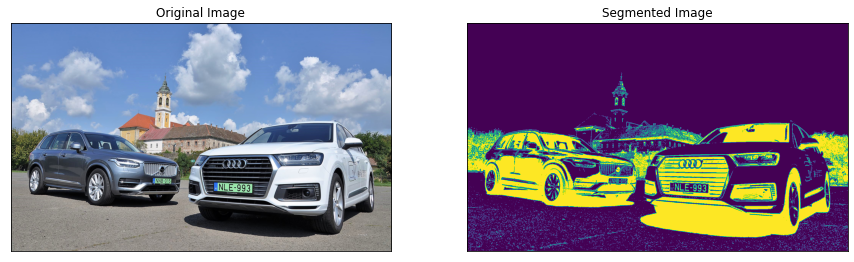

In [98]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()

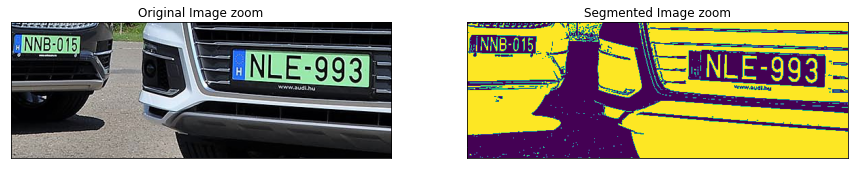

In [99]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img[800:1000,740:1300])
plt.title('Original Image zoom'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res[800:1000,740:1300])
plt.title('Segmented Image zoom'), plt.xticks([]), plt.yticks([])
plt.show()

### Find connected components

In [100]:
regions = measure.label(res,connectivity=1,background=-10)
patches = measure.regionprops(regions)

In [101]:
len(patches)

15327

### Boundary box
x_min, y_min, x_max, y_max

In [102]:
print(patches[5].area, patches[5].bbox)

24 (285, 806, 290, 814)


### TASK: select regions which fulfill the following conditions
 * area > 100
 * area < 0.3 * area of the whole image
 * aspect ratio is between 2 and 5 and lying flat
 
 1. Draw rectangles around the objects
 2. Plot the corresponding part from the original image
   * matplotlib.patches.Rectangle( (x0, y0), w, h )
   * see example below
 

In [103]:
def bool_area_superior(patch, threshold):
  area = patch.area # calcul de l'aire = delta_x * delta_y
  return area > threshold

In [104]:
def bool_compare_to_image(patch, image, threshold):
  area_of_image = image.shape[0] * image.shape[1]
  area_of_patch = patch.area
  return area_of_patch < threshold * area_of_image

In [105]:
def bool_aspect_ratio(patch, min_threshold, max_threshold):
  delta_x = np.abs(patch.bbox[2]-patch.bbox[0])
  delta_y = np.abs(patch.bbox[3]-patch.bbox[1])

  ratio = delta_y/delta_x

  return ratio > min_threshold and ratio < max_threshold

In [106]:
res_patches = []

THRESHOLD_AREA = 100

MIN_THRESHOLD = 2
MAX_THRESHOLD = 5

THRESHOLD_AREA_TO_IMAGE = 0.3

for patch in patches :
  condition = bool_area_superior(patch, THRESHOLD_AREA) and bool_compare_to_image(patch, img, THRESHOLD_AREA_TO_IMAGE) and bool_aspect_ratio(patch, MIN_THRESHOLD, MAX_THRESHOLD)
  if condition :
    res_patches.append(patch)


len(res_patches)

23

In [107]:
def plot_boxes(patches, img): 
  fig, (ax1) = plt.subplots(1,figsize=(20,20))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);
  for patch in patches :

    width = np.abs(patch.bbox[2]-patch.bbox[0])
    height = np.abs(patch.bbox[3]-patch.bbox[1])

    anchor_x = patch.bbox[0]
    anchor_y = patch.bbox[1]
    
    rectBorder = matplotlib.patches.Rectangle(\
                (anchor_y, anchor_x),  height, width, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

  plt.show()

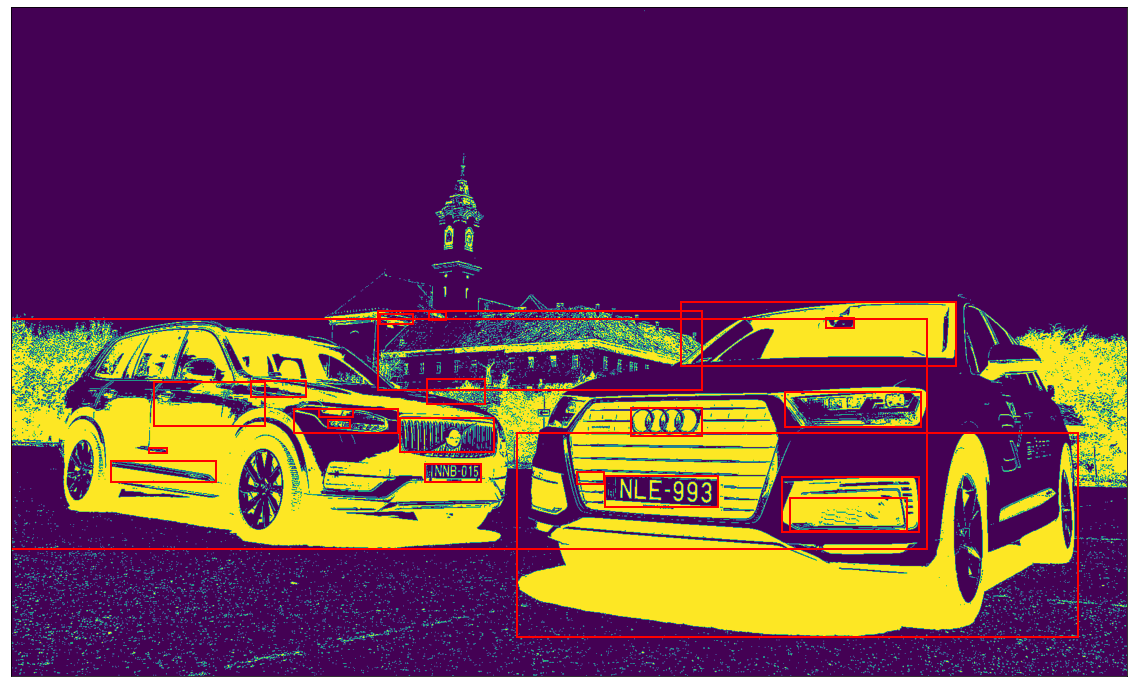

In [108]:
plot_boxes(res_patches, res)

## Pattern matching

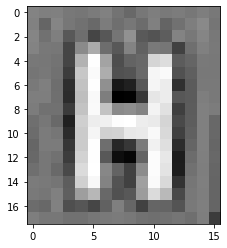

In [109]:
fig, ax = plt.subplots()
ax.imshow(gimg[863:881,1067:1083],cmap='gray');

### Create pattern

In [110]:
template = gimg[863:881,1067:1083]
w, h = template.shape[::-1]

### Find pattern

In [111]:
res = cv2.matchTemplate(gimg,template,cv2.TM_CCOEFF_NORMED)

In [112]:
np.shape(res)

(1183, 1985)

### Fantastic beasts and where to find them

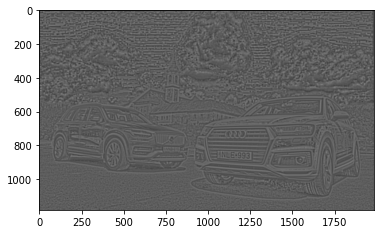

In [113]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(res,cmap='gray')
plt.show()

In [114]:
threshold = 0.48
loc = np.where( res >= threshold)
print(loc)

(array([160, 861, 862, 863, 864, 865]), array([ 788, 1067, 1067, 1067, 1067, 1067]))


In [115]:
res.shape

(1183, 1985)

### TASK
 1. plot the corresponding parts of the image
 2. decrease the threshold to 0.6, 0.5, 0.45 (do not go much below!)

In [116]:
res[1:5,10:20]

array([[-0.11714682, -0.11397953, -0.10727425, -0.10783458, -0.10640975,
        -0.10666932, -0.10735336, -0.11252733, -0.11153922, -0.11049014],
       [-0.1042201 , -0.10159072, -0.09669492, -0.0997415 , -0.09977765,
        -0.10065806, -0.10030249, -0.10701413, -0.10818825, -0.11051654],
       [-0.09319063, -0.09050662, -0.08494909, -0.08907625, -0.08974929,
        -0.0926564 , -0.09279149, -0.10137177, -0.1038921 , -0.1110579 ],
       [-0.06915455, -0.06862263, -0.0618102 , -0.06750578, -0.06644028,
        -0.06883509, -0.06948379, -0.08387866, -0.0852615 , -0.09456419]],
      dtype=float32)

In [117]:
def plot_part_of_image(img, coord, size=20):
  part_of_image = img[coord[0]:coord[0]+size,coord[1]:coord[1]+size]

  plt.imshow(part_of_image)
  plt.show()

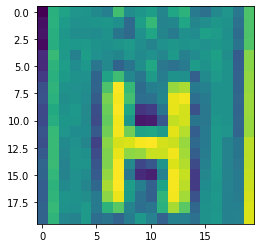

In [118]:
coord = [860,1065]
plot_part_of_image(gimg, coord, 20)

### TASK
 1. write a code which resizes the pattern (factors: 0.5-2) and searches for its matches, can you find the other H?
<pre>cv2.resize(template,new_x,new_y)</pre> does the trick
 2. plot the found plate number with the numbers included (just estimate the size)

In [119]:
def resize_template(template, factor):

  new_size_x = int(factor * template.shape[0])
  new_size_y = int(factor * template.shape[1])

  new_template = cv2.resize(template, (new_size_x,new_size_y),fx=factor, fy=factor)
  return new_template

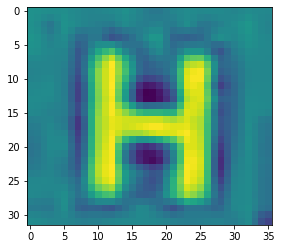

In [120]:
plt.imshow(resize_template(template,2))
plt.show()

In [121]:
def find_template(image, template, threshold):
  gimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  res = cv2.matchTemplate(gimg,template,cv2.TM_CCOEFF_NORMED)
  gimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  loc = np.where( res >= threshold)
  return loc


In [122]:
def find_template_with_factor(image, template, threshold, factor):
  new_template = resize_template(template, factor)
  loc = find_template(image, new_template, threshold)
  return loc

In [123]:
find_template(img, template, 0.48)

(array([160, 861, 862, 863, 864, 865]),
 array([ 788, 1067, 1067, 1067, 1067, 1067]))

[863, 1066]


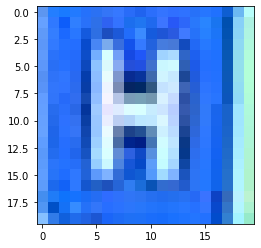

[864, 1066]


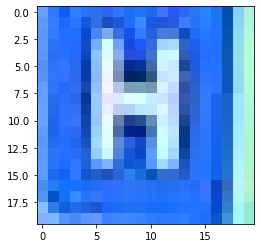

[865, 1066]


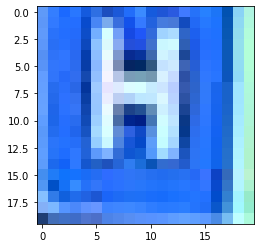

In [124]:
points_of_interest = find_template_with_factor(img, template, 0.55, 1)
for i in range(len(points_of_interest[0])):
  coord = [points_of_interest[0][i],points_of_interest[1][i]]
  print(coord)
  plot_part_of_image(img, coord, 20)

[392, 796]


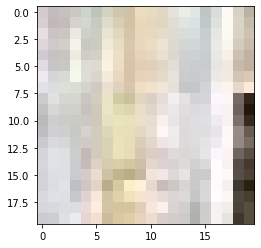

[393, 796]


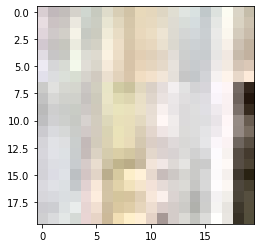

[604, 617]


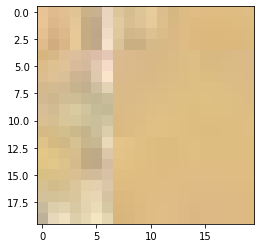

[641, 823]


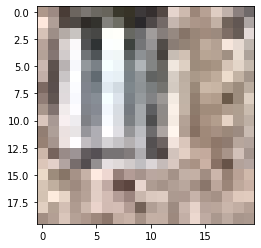

[642, 823]


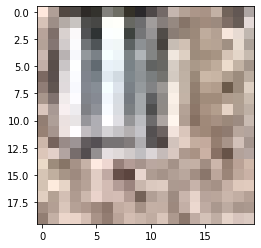

[750, 839]


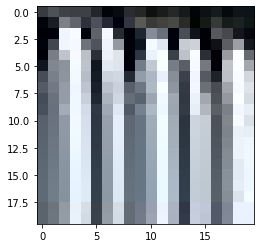

[751, 823]


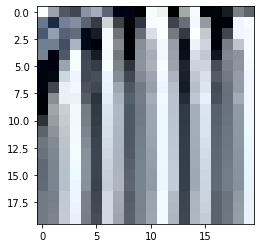

[752, 823]


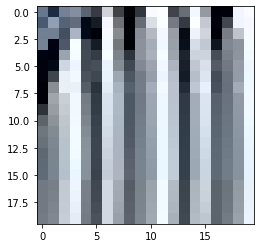

[753, 823]


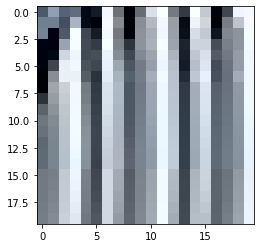

[762, 823]


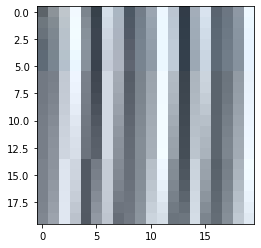

[763, 823]


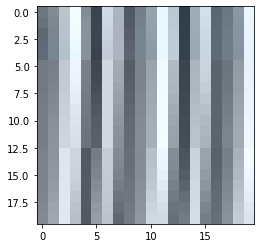

[764, 823]


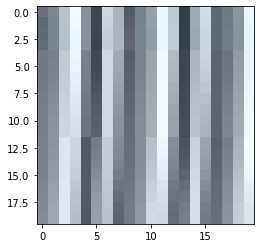

[765, 823]


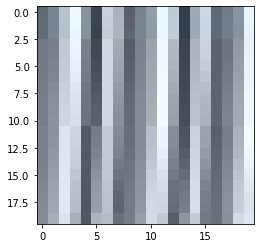

[766, 823]


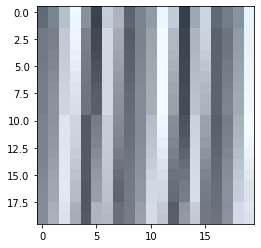

[767, 823]


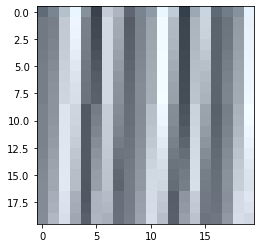

[770, 847]


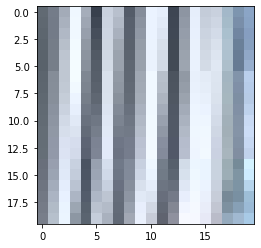

[771, 831]


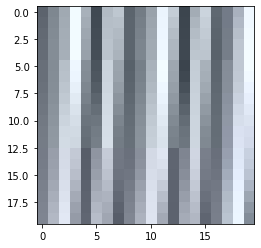

[771, 847]


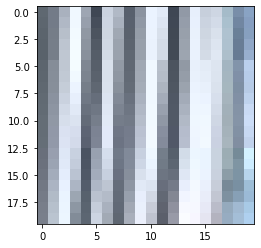

[772, 831]


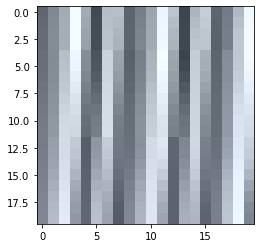

[772, 847]


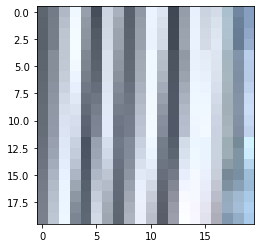

[773, 831]


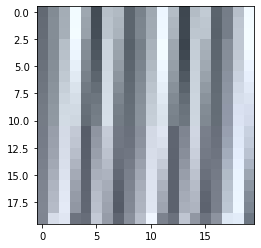

[774, 814]


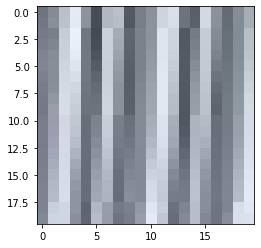

[774, 831]


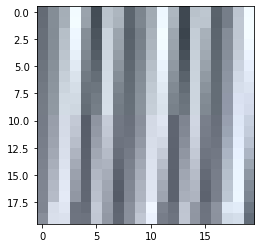

[774, 1125]


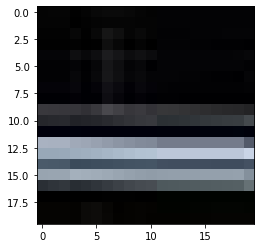

[774, 1128]


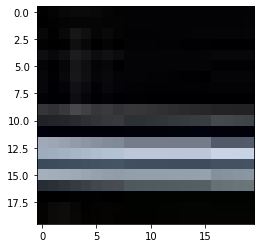

[775, 831]


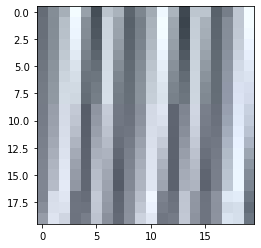

[776, 831]


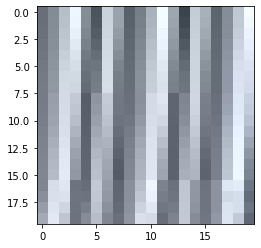

[782, 871]


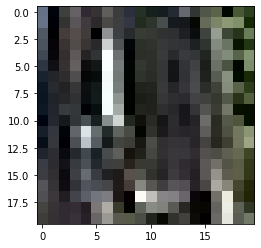

[832, 745]


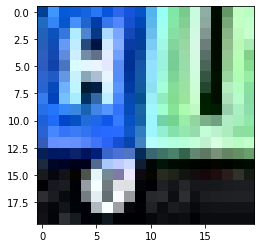

[833, 745]


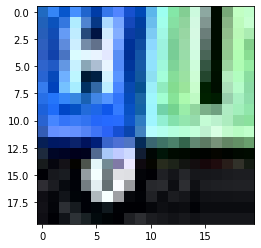

In [125]:
points_of_interest = find_template_with_factor(img, template, 0.55, 0.6)
for i in range(len(points_of_interest[0])):
  coord = [points_of_interest[0][i],points_of_interest[1][i]]
  print(coord)
  plot_part_of_image(img, coord, 20)


## Homework
Try to find the letters on the number plates. Please note, that any other route is possible, I even encourage you to try to find better methods if you have the ambition.
By the end of the class after thresholding and looking for horizontal patches you should end up with about two dozen of them matching the criteria. Go through them and perform the following:
* Use k-means clustering with k=2 on these rectangles. If the original patch was a number plate we expect this to find letters and other dirt. Let us call smallpatches these patches found on the patches.
* Discard smallpatches which:
   - are larger than 1/5th of the patch
   - are smaller than 1/100th of the patch
   - are shorter than the half of the patch (in the vertical direction)
   - have an aspect ratio < 0.1
   - have an aspect ratio > 1.2
   - have less than 4 or more than 10 smallpatches matching the above criteria.
   
* Finally keep only those patches the relative height of which differs less than 5% from the median

Check the images rendszam*.png in the zip file. These are the images I recieved with and without the last rule
   

In [126]:
chemin = "drive/MyDrive/BME/Artificial_Intelligence_in_Data_Science/class_2/"
img = mpimg.imread(chemin+"DSC_2144.jpg")

Needed functions for homework, the previous code have also to be executed in order to get the resulting patches

In [127]:
def plot_boxes(patches, img): 
  fig, (ax1) = plt.subplots(1,figsize=(20,20))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);
  
  for patch in patches :

    width = np.abs(patch.bbox[2]-patch.bbox[0])
    height = np.abs(patch.bbox[3]-patch.bbox[1])

    anchor_x = patch.bbox[0]
    anchor_y = patch.bbox[1]
    
    rectBorder = matplotlib.patches.Rectangle(\
                (anchor_y, anchor_x),  height, width, edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

  plt.show()

Conditions

In [128]:
def bool_compare_to_image(patch, image, threshold):
  area_of_image = image.shape[0] * image.shape[1]
  area_of_patch = patch.area
  return area_of_patch < threshold * area_of_image

In [129]:
def bool_aspect_ratio(patch, min_threshold, max_threshold):
  delta_x = np.abs(patch.bbox[2]-patch.bbox[0])
  delta_y = np.abs(patch.bbox[3]-patch.bbox[1])

  ratio = delta_y/delta_x

  return ratio > min_threshold and ratio < max_threshold

In [130]:
def bool_area_superior(patch, threshold):
  area = patch.area
  return area > threshold

In [131]:
def bool_vertical(patch, img_plaque, threshold_vertical):
  return np.abs(patch.bbox[1]-patch.bbox[3])<img_plaque.shape[0]*threshold_vertical

In [132]:
def bool_divergence(patch,patches, threshold):
  mean_height = 0
  for patch_i in patches :
    mean_height+=np.abs(patch_i.bbox[0]-patch_i.bbox[2])
  mean_height/=len(patches)

  height = np.abs(patch.bbox[0]-patch.bbox[2])
  return (mean_height-height)/mean_height < threshold

# Automatic

In [133]:
# the function to find small patcher and the filtration after
def run_for_a_patch(img_patch, res, threshold_area, threshold_area_to_image, min_threshold, max_threshold, threshold_vertical,threshold_div):

  # creation of the connected components
  smallregions = measure.label(res,connectivity=1,background=-10)
  smallpatches = measure.regionprops(smallregions)

  # the list of resulting smallpatches through the first layer of filter
  res_smallpatches = []

  # we filter the smallpatches
  for smallpatch in smallpatches :
    condition = bool_area_superior(smallpatch, threshold_area) and\
                bool_compare_to_image(smallpatch, img_patch, threshold_area_to_image) and\
                bool_aspect_ratio(smallpatch, min_threshold, max_threshold) and\
                bool_vertical(smallpatch, img_patch, threshold_vertical)
                

    if condition :
      res_smallpatches.append(smallpatch)

  # the other layer on the divergence of the height
  # I am not sure if I understand the condition
  res_smallpatches_final = []

  for patch in res_smallpatches :
    
    condition = bool_divergence(patch, res_smallpatches, threshold_div)

    if condition :
      res_smallpatches_final.append(patch)

  return res_smallpatches_final

In [134]:
# segment a patch with Kmeans
# so maybe we could have use a randomForest to do the cluster
def segment_patches(img_patch):
  rgb = img_patch.reshape((-1,3))
  kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb)

  pred = kmeans.predict(rgb)
  res = pred.reshape((img_patch.shape[0],img_patch.shape[1]))
  return res

In [135]:
# main function that will show all the patch and the small patches
def run_through_patches(img, res_patches, dict_param):

  final_patch = []

  for patch in res_patches:
    
    # get the coordoniates
    print("Coord : (",patch.bbox[0],patch.bbox[2], patch.bbox[1],patch.bbox[3],")")
    img_patch = img[patch.bbox[0]:patch.bbox[2], patch.bbox[1]:patch.bbox[3]]

    # segment with K-means a patch
    res = segment_patches(img_patch)


    # parameters
    threshold_area = res.shape[0]*res.shape[1]/100
    threshold_area_to_image = dict_param["threshold_area_to_image"]
    min_threshold = dict_param["min_threshold"]
    max_threshold = dict_param["max_threshold"]
    threshold_vertical = dict_param["threshold_vertical"]
    threshold_div = dict_param["threshold_div"]

    # does what we want for just a patch with the image segmented
    res_smallpatches = run_for_a_patch(img_patch, res, threshold_area, threshold_area_to_image, min_threshold, max_threshold,threshold_vertical,threshold_div)


    # filtration on the number of smallpatches in a patch
    # the first "if" is redundant with the seond "if"
    if len(res_smallpatches) > 0 :
      if len(res_smallpatches) > 4 and len(res_smallpatches) < 10:
        # the patch are and smallpatches are displayed
        plot_boxes(res_smallpatches, img_patch)

        # we put the patch and smallpitch in a list that will be returned
        final_patch.append({
                            "patch": patch,
                            "smallpatches": res_smallpatches
                            }
                          )

  return final_patch

## Execution

In [136]:
# dictionary of the parameters
dict_param = {
              "threshold_area" : None,
              "threshold_area_to_image" : 1/5,
              "min_threshold" : 0.1,
              "max_threshold" : 1.2,
              "threshold_vertical":0.5,
              "threshold_div":0.05
             }

It seems that we get what we wanted according to the zip file. If we change some parameters, we can some different result.

Coord : ( 529 643 1200 1693 )
Coord : ( 545 686 657 1239 )
Coord : ( 546 561 749 780 )
Coord : ( 550 568 662 721 )
Coord : ( 557 576 1461 1510 )
Coord : ( 560 971 0 1642 )
Coord : ( 667 711 745 850 )
Coord : ( 670 699 431 528 )
Coord : ( 672 751 256 456 )
Coord : ( 690 753 1387 1630 )
Coord : ( 719 768 1111 1239 )
Coord : ( 720 764 508 694 )
Coord : ( 720 734 552 613 )
Coord : ( 736 798 698 865 )
Coord : ( 741 754 569 608 )
Coord : ( 763 1129 906 1912 )
Coord : ( 791 800 247 280 )
Coord : ( 814 852 180 367 )
Coord : ( 819 852 742 842 )


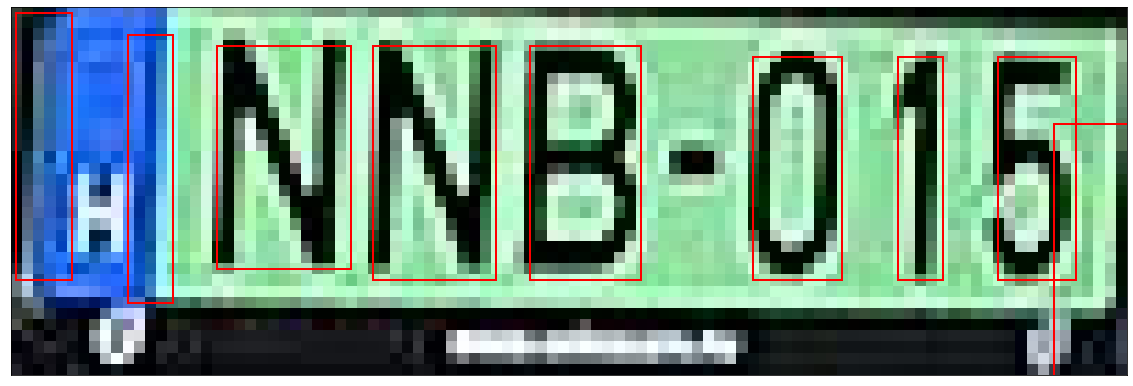

Coord : ( 833 854 1014 1063 )
Coord : ( 841 896 1065 1267 )


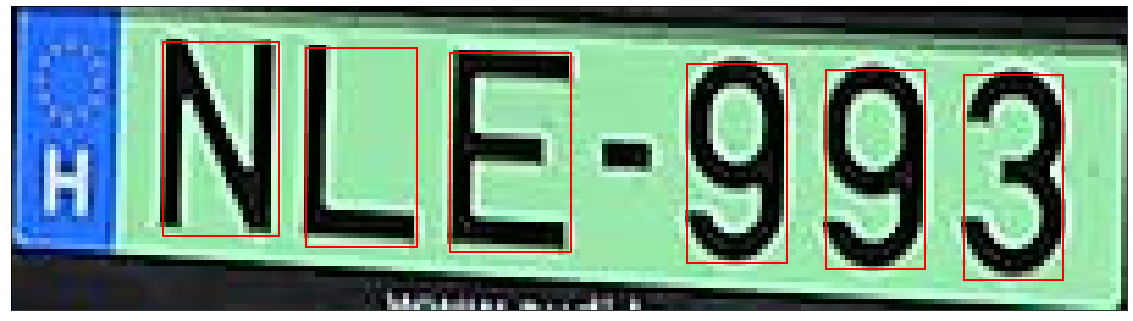

Coord : ( 842 941 1381 1627 )
Coord : ( 880 940 1396 1605 )


[{'patch': <skimage.measure._regionprops.RegionProperties at 0x7fa75e24ce50>,
  'smallpatches': [<skimage.measure._regionprops.RegionProperties at 0x7fa7651b2850>,
   <skimage.measure._regionprops.RegionProperties at 0x7fa76daea0d0>]},
 {'patch': <skimage.measure._regionprops.RegionProperties at 0x7fa75e225150>,
  'smallpatches': [<skimage.measure._regionprops.RegionProperties at 0x7fa76db95d50>,
   <skimage.measure._regionprops.RegionProperties at 0x7fa76dba4a90>]}]

In [137]:
run_through_patches(img, res_patches,dict_param)